In [2]:
from DataGenerator import TimeSeriesGenerator, suddenDrift, generateSeasonality, generateTrend, incrementalDrift
from conditions import scenarios
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from grouped_series import ExperimentTracker    
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from TimeSeriesGradientBoosting import TimeSeriesGradientBoosting
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, RidgeCV

In [34]:
onehot1 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

onehot2 = ColumnTransformer([('one_hot_encoder', OneHotEncoder(
), make_column_selector(dtype_include=object))], remainder=StandardScaler())

hybrid_vars = [0,1, 2, 3, 4, 5, 6, 7, -3, -2, -1]
hybrid_model = TimeSeriesGradientBoosting(model1 = LinearRegression(), model2 = XGBRegressor(), model1_variables = hybrid_vars)

hybrid_xgb_pipe = Pipeline([
    ('preprocessor', onehot1),
    ('regressor', hybrid_model)
])

sgd_pipe = Pipeline([
    ('preprocessor', onehot2),
    ('regressor', SGDRegressor())
])

In [35]:
def full_run():
    products = []
    customers = []
    for i in range(2):
        product = TimeSeriesGenerator(size=365, amountOfVariables=7)
        customer = TimeSeriesGenerator(size=365, amountOfVariables=3)
        products.append(product)
        customers.append(customer)
    thesis = ExperimentTracker(products, customers, scenarios())
    thesis.runExperiment(algorithms=[hybrid_xgb_pipe, sgd_pipe], algorithm_name=["Gradient boosted decision tree", "Linear regression"], online=[False, False])
    return thesis


In [36]:
thesis = full_run()

Finished experiment! Elapsed time: 0.44081974029541016, total Elapsed time: 0.44081974029541016, Algorithm: Gradient boosted decision tree Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Important
Finished experiment! Elapsed time: 0.5739297866821289, total Elapsed time: 1.014749526977539, Algorithm: Gradient boosted decision tree Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Half observed, importance: Important
Finished experiment! Elapsed time: 0.4840066432952881, total Elapsed time: 1.4987561702728271, Algorithm: Gradient boosted decision tree Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Unobserved, importance: Important
Finished experiment! Elapsed time: 0.4955880641937256, total Elapsed time: 1.9943442344665527, Algorithm: Gradient boosted decision tree Type: Sudden Drift, Dropped variables: None, magnitude: Small, Drift time: Fully observed, importance: Medium
Finishe

In [37]:
results = thesis.resultsToDF()

In [38]:
results[["Algorithm","SMAPE", "Drift type", "Drift time", "Drift magnitude"]].groupby(["Algorithm","Drift type", "Drift time", "Drift magnitude"]).aggregate(["mean", "std", "min", "max"])

SMAPE  \
                                                                                     mean   
Algorithm                      Drift type        Drift time     Drift magnitude             
Gradient boosted decision tree Incremental Drift Fully observed Large            4.501667   
                                                                Small            2.588333   
                                                 Half observed  Large            7.910000   
                                                                Small            2.611667   
                                                 Unobserved     Large            8.197500   
                                                                Small            2.787500   
                               No Drift          No Drift       No Drift         2.080000   
                               Sudden Drift      Fully observed Large            4.399167   
                                                                Small            2.515000   
                                                 Half observed  Large            5.631667   
                                                                Small            2.353333   
                                                 Unobserved     Large            9.762500   
                                                                Small            2.984167   
                               Sudden Shock      3 days         Large            2.535000   
                                                                Small            2.165000   
                                                 7 days         Large            2.567500   
                                                                Small            2.257500   
Linear regression              Incremental Drift Fully observed Large            3.614167   
                                                                Small            2.934167   
                                                 Half observed  Large            4.544167   
                                                                Small            3.051667   
                                                 Unobserved     Large            6.854167   
                                                                Small            3.277500   
                               No Drift          No Drift       No Drift         2.870000   
                               Sudden Drift      Fully observed Large            3.625833   
                                                                Small            2.945000   
                                                 Half observed  Large            4.130833   
                                                                Small            2.958333   
                                                 Unobserved     Large            7.367500   
                                                                Small            3.261667   
                               Sudden Shock      3 days         Large            2.952500   
                                                                Small            2.897500   
                                                 7 days         Large            2.940000   
                                                                Small            2.880000   

                                                                                           \
                                                                                      std   
Algorithm                      Drift type        Drift time     Drift magnitude             
Gradient boosted decision tree Incremental Drift Fully observed Large            1.691115   
                                                                Small            0.332671   
                                                 Half observed  Large            4.473605   
                                                                Small            0.4

In [39]:
results.sort_values("SMAPE", ascending=False)   

,Algorithm,Dropped variable,Drift type,Drift magnitude,Variable importance,Drift time,MSE,SMAPE
216,Linear regression,0.0,Sudden Drift,Large,Important,Unobserved,730.897452,16.19
52,Gradient boosted decision tree,0.0,Sudden Drift,Large,Important,Unobserved,703.112610,16.17
93,Gradient boosted decision tree,3.0,Sudden Drift,Large,Important,Unobserved,680.748741,15.88
11,Gradient boosted decision tree,NaN,Sudden Drift,Large,Important,Unobserved,659.013405,15.52
134,Gradient boosted decision tree,6.0,Sudden Drift,Large,Important,Unobserved,642.442146,15.33
...,...,...,...,...,...,...,...,...
149,Gradient boosted decision tree,6.0,Incremental Drift,Small,Unimportant,Unobserved,13.178609,2.04
25,Gradient boosted decision tree,NaN,Incremental Drift,Small,Unimportant,Half observed,13.235018,2.04
130,Gradient boosted decision tree,6.0,Sudden Drift,Small,Unimportant,Half observed,12.582260,2.03
131,Gradient boosted decision tree,6.0,Sudden Drift,Small,Unimportant,Unobserved,13.068194,2.03


Next up is changepoint/drift detection!
Let's start with doing it on a single series and then ramp up complexity to multivariate cases

In [40]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.consts import TimeSeriesData

In [41]:
test_prod = TimeSeriesGenerator(size=365, amountOfVariables=10)
#generateTrend(test_prod, indices=1, magnitude=3)
suddenDrift(test_prod, variables=0, magnitude=3, time=140)
generateSeasonality(test_prod, 6, 2)
test_prod = test_prod.toDataFrame()
test_prod = test_prod.astype(float)

In [42]:
tsd = TimeSeriesData(value= test_prod["Response"], time = test_prod.index)


In [43]:
det = BOCPDetector(tsd)
changepoint = det.detector(threshold=0.9)

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

C:\Users\chidi\anaconda3\envs\dbconnect\lib\site-packages\ax\core\parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



In [44]:
changepoint

[BOCPDChangePoint(start_time: 2017-05-20T00:00:00.000000000, end_time: 2017-05-20T00:00:00.000000000, confidence: 0.9789737411774339, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response),
 BOCPDChangePoint(start_time: 2017-05-21T00:00:00.000000000, end_time: 2017-05-21T00:00:00.000000000, confidence: 0.9799999940954781, model: BOCPDModelType.NORMAL_KNOWN_MODEL, ts_name: Response)]

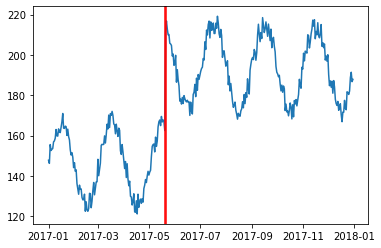

In [45]:
det.plot(changepoint);

In [46]:
test_prod.iloc[[110]]

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-04-21,25.576258,26.605038,2.111045,15.707047,21.914527,23.963883,24.406188,10.019339,30.431647,24.41993,128.512764,2017.0,16.0,5.0
